In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

C:\Users\Daria\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#df = pd.read_csv('email.csv').dropna(subset= ['content'])

In [3]:
#df['tokens'] = df.one_line.apply(lambda x: str(x).split(" "))

In [4]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [5]:
#documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(df.tokens))]

In [6]:
with open('raw_threads.txt') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 
content = filter(lambda x: len(x) > 0, content)
content = list(filter(lambda x: x[0] != '#', content))
print(len(content))

124


In [7]:
tokens = [email.split(" ") for email in content]

In [8]:
model_doc2vec= Doc2Vec.load("d2v-5.model")

In [9]:
model_doc2vec.docvecs[0]

array([-2.5894747 , -0.6310076 ,  0.00903296, -0.3139348 ,  1.3027536 ],
      dtype=float32)

In [10]:
from bs4 import BeautifulSoup
from nltk import word_tokenize

In [11]:
def clean_text_from_html(text):
    return BeautifulSoup(text, "lxml").text

def text_to_tokens(text):
    cleaned = clean_text_from_html(str(text))
    tokens = word_tokenize(text)
    return [word for word in tokens if word.isalpha()]

In [12]:
X_docs = np.array([model_doc2vec.infer_vector(text_to_tokens(message)) for message in content])

In [13]:
pca_docs = PCA(n_components=2)
result_docs = pca_docs.fit_transform(X_docs)

In [14]:
X_cluster = X_docs

In [15]:
result_docs_cluster = pca_docs.transform(X_cluster)

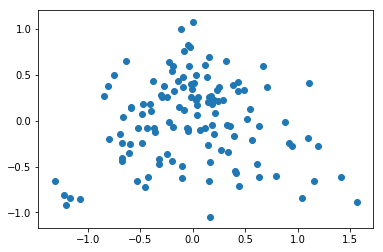

In [16]:
plt.scatter(result_docs_cluster[:,0], result_docs_cluster[:,1])

In [17]:
from sklearn.cluster import DBSCAN, KMeans

In [18]:
kmeans = KMeans(18)
y = kmeans.fit_predict(X_cluster)

In [19]:
with open('raw_threads.txt') as f:
    s = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
s = [x.strip() for x in s] 
s = filter(lambda x: len(x) > 0, s)
real_clusters = np.zeros((len(content), ))
k = 0
for i, message in enumerate(s, 0):
    if (message[0] == '#'):
        k = k +  1
    else:
        real_clusters[i - k] = k-1
print(real_clusters)
print(y)

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.
  2.  2.  3.  3.  3.  4.  4.  4.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.
  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.
  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11.
 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 13.
 13. 13. 13. 14. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17. 17. 17. 17. 17.]
[ 5  5  8 12  5  5  8  8 15  3 15  3  3 15  5 12  8  6 12 12  9  1  4  2
  2  2 10 10 12 10  1 10  9 16  9 13  9  1  4  7  7 13  4  7  6 13  9  7
  9  1 14  8 13  1  9  8 13 10  0 15  7 10 12 15  3 17  0 10  0  5  7 15
  0 12 10  4  4  4  6  8 12 12 10 14  7 13  1 14  1  7  6  1 14 12  1 12
  7  7  7  7 16  6 12  3 12 12  5 12  5  7  7  8  4  8  0 11 11 13 13 13
  1  1 13 16]


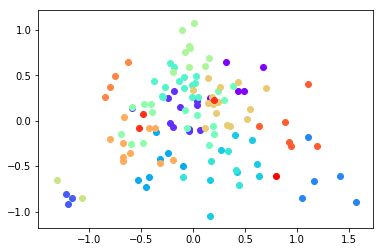

In [20]:
from matplotlib.pyplot import cm
color=iter(cm.rainbow(np.linspace(0,1,18)))
for i in range(18):
    c = next(color)
    plt.scatter(result_docs_cluster[y == i][:,0], result_docs_cluster[y == i][:,1], color=c)

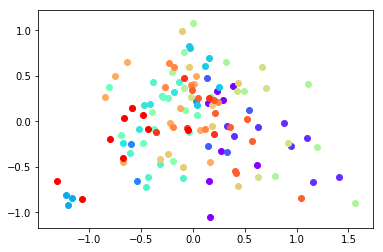

In [21]:
color=iter(cm.rainbow(np.linspace(0,1,18)))
for i in range(18):
    c = next(color)
    plt.scatter(result_docs_cluster[real_clusters == i][:,0], result_docs_cluster[real_clusters == i][:,1], color=c)

In [22]:
from sklearn import metrics

In [30]:
print(metrics.adjusted_rand_score(real_clusters, y))
print(metrics.completeness_score(real_clusters, y))

0.11022918468806739
0.5107228189319651


In [24]:
from scipy.spatial import distance
idx = np.array(range(len(content)))
idx_centers = []
i_doc_mins = []
doc_coords_mins = []
idx_externs = []
i_doc_maxs = []
doc_coords_maxs = []
for i, center in enumerate(kmeans.cluster_centers_):
    docs_in_cluster = X_cluster[y == i]
    i_docs_in_cluster = idx[y == i]
    min_dist = 9_999_999_999
    doc_coords_min = 0
    i_min_dist = -1
    i_doc_min = -1
    max_dist = 0
    doc_coords_max = 0
    i_max_dist = -1
    i_doc_max = -1
    for i_doc, doc in enumerate(docs_in_cluster):
#         curr_dist = np.linalg.norm(doc[0:2]-center[0:2])
        curr_dist = distance.euclidean(doc, center)
        if (curr_dist > max_dist):
            max_dist = curr_dist
            i_max_dist = i_docs_in_cluster[i_doc]
            i_doc_max = i_doc
            doc_coords_max = doc
        if (curr_dist < min_dist):
            min_dist = curr_dist
            i_min_dist = i_docs_in_cluster[i_doc]
            i_doc_min = i_doc
            doc_coords_min = doc
    idx_centers.append(i_docs_in_cluster[i_doc_min])
    i_doc_mins.append(i_doc_min)    
    doc_coords_mins.append(doc_coords_min)
    idx_externs.append(i_docs_in_cluster[i_doc_max])
    i_doc_maxs.append(i_doc_max)
    doc_coords_maxs.append(doc_coords_max)

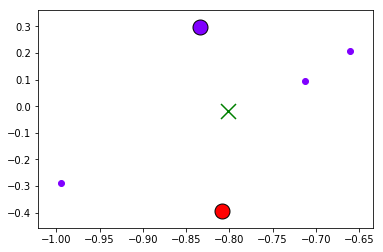

In [25]:
color=iter(cm.rainbow(np.linspace(0,1,18)))
i = 6
c = next(color)
plt.scatter(X_cluster[y == i][:,0], X_cluster[y == i][:,1], color=c)
center_id = i_doc_mins[i]
extern_id = i_doc_maxs[i]
plt.scatter(doc_coords_mins[i][0], doc_coords_mins[i][1], color=c, marker='o', edgecolors='black', s=15**2)
plt.scatter(doc_coords_maxs[i][0], doc_coords_maxs[i][1], color='red', marker='o', edgecolors='black', s=15**2)
plt.scatter(kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1], color='green', marker='x', edgecolors='black', s=15**2)

In [26]:
for i in range(18):
    print("\n\nCluster {0}:\n".format(i))
    print(" Center: ")
    print (content[idx_centers[i]])
    print()
    print(" Extern: ")
    print (content[idx_externs[i]])
    print('\n')



Cluster 0:

 Center: 
I found this picture of my boat on the internet!

 Extern: 
I checked the boat and it is 17 ft, 7 in. long, it is a Capri model # 1750CH, it has a am/fm cass. The motor is 3.0L MerCruiser Alpha Sterndrive (135 hp)




Cluster 1:

 Center: 
Daren, Will you let me know when this change has been made? I need to get some payments finaled by 3pm tomorrow.

 Extern: 
fyi, any thoughts? rick




Cluster 2:

 Center: 
Unless I hear otherwise by late today, I will assume that your executive manager has reviewed and approved your section. Please call if that is not the case. We will make a distribution of the book late today. We expect additional information from Rex Rogers and possible changes to the information provided by Tim Despain and Rick Carson. Again, thank you. sent by: Laura Valencia Executive Assistant Tel: 713-853-6485 Fax: 713/853-2534 CONFIDENTIALITY NOTICE The information contained in this email may be confidential and/or privileged. This email is intended

In [27]:
sum(y == 1)

11

In [28]:
for i in range(17):
    print("\n\nCluster {0}:\n".format(i))
    docs_i = np.array(content)[y == i]
    for k in range(min(sum(y == i), 10)):
        print ((docs_i[k]))
        print('\n')



Cluster 0:

Thought you would like to see the "cool" yours truly with Quiet Riot. I am thinking about joining the band... ?


Eric and I will discuss this and get back with you. In the meantime we had better not see you at any photo ops with Poison or Warrant.


I found this picture of my boat on the internet!


I checked the boat and it is 17 ft, 7 in. long, it is a Capri model # 1750CH, it has a am/fm cass. The motor is 3.0L MerCruiser Alpha Sterndrive (135 hp)


cool, let me know if you need anything




Cluster 1:

fyi, any thoughts? rick


I think you're cheating trying to get a fixed amount.... I'll give $1 per pin. Good luck, John Liz


Thanks for the explanation, Diana! Kate


Enerfin TETCO Victor, Can we go this far back? Please advise. Cindy -----------------


Thanks Darren, I appreciate it. We all know how often Enerfin's numbers change. Chances are we would have had to reverse any entry we made.


Daren, Will you let me know when this change has been made? I need to get 